# Outpainting

[Link](https://huggingface.co/docs/diffusers/v0.29.0/en/advanced_inference/outpaint#outpainting)

Outpainting은 기존 이미지를 보존하면서 경계 너머의 부분을 새롭게 만들어내는 것입니다. Inpainting과 마찬가지로 원래 원본의 특정 부분은 고정한채 다른 부분을 원본과 매끄럽게 이어지도록 만드는 것을 목표로 합니다. ControlNet을 주로 활용합니다. 

In [1]:
# controlnet_aux 라이브러리 설치

!pip install -q controlnet_aux

## Image preparation

Stable Diffusion XL(SDXL)은 1024x1024 크기의 이미지에서 가장 잘 작동합니다. 그러나 리소스가 가능한 선에서 resize를 통해서 이미지 크기를 조정할 수 있습니다. 

In [2]:
import random
import requests
import torch

from controlnet_aux import ZoeDetector
from PIL import Image, ImageOps

from diffusers import (
    AutoencoderKL,
    ControlNetModel,
    StableDiffusionXLControlNetPipeline,
    StableDiffusionXLInpaintPipeline,
)

def scale_and_paste(original_image):
    aspect_ratio = original_image.width / original_image.height
    
    # 이미지의 가로 세로 비율에 따라 크기 조정
    if original_image.width > original_image.height:
        new_width = 1024
        new_height = round(new_width / aspect_ratio)
    else:
        new_height = 1024
        new_width = round(new_height * aspect_ratio)
    
    resized_original = original_image.resize((new_width, new_height), Image.LANCZOS) # 이미지 크기 조정
    white_background = Image.new("RGB", (1024, 1024), (255, 255, 255)) # 흰색 배경 생성
    x = (1024 - new_width) // 2
    y = (1024 - new_height) // 2
    white_background.paste(resized_original, (x, y), resized_original) # 이미지 중앙에 붙이기
    
    return resized_original, white_background

original_image = Image.open("original-jordan.png").convert("RGBA")
# original_image = Image.open("addidas_footbal.png").convert("RGBA")
resized_img, white_bg_image = scale_and_paste(original_image)

/home/work/anaconda3/envs/diffusion/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/work/anaconda3/envs/diffusion/lib/python3.9/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(
/home/work/anaconda3/envs/diffusion/lib/python3.9/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, i

원치 않는 details을 추가하지 않기 위해서는 ZoeDepth estimator를 사용해 생성 중에 추가 guidance를 제공하고 객체가 원본 이미지와 일관되게 유지하도록 합니다. 

/home/work/anaconda3/envs/diffusion/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/work/anaconda3/envs/diffusion/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


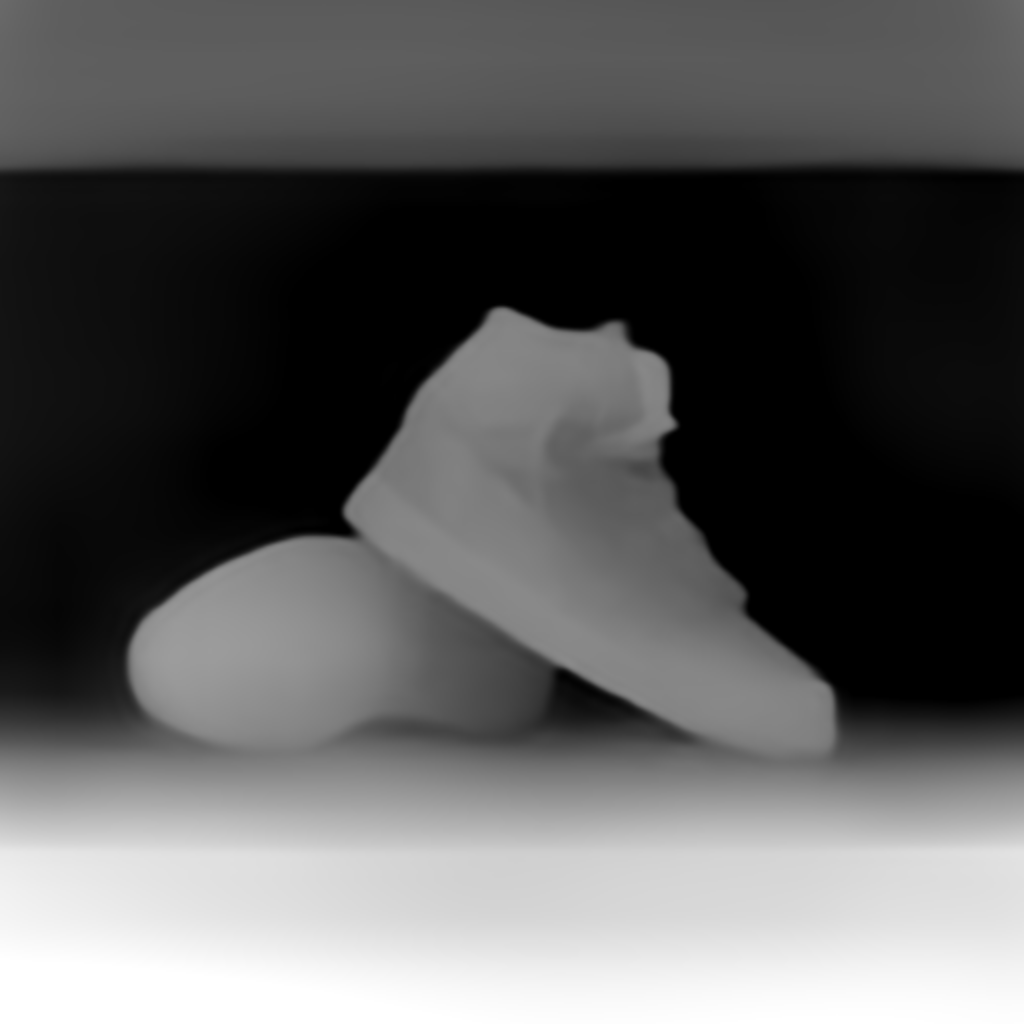

In [3]:
zoe = ZoeDetector.from_pretrained("lllyasviel/Annotators")
image_zoe = zoe(white_bg_image, detect_resolution=512, image_resolution=1024)
image_zoe

## Outpaint

이미지가 준비되면 Inpainting용으로 학습된 SDXL ControlNet(controlnet-inpaint-dreamer-sdxl)을 사용하여 객체 주변의 흰색 영역에 새로운 콘텐츠를 생성할 수 있습니다.

inpainting ControlNet, ZoeDepth model, VAE를 로드하고 StableDiffusionXLControlNetPipeline에 전달합니다. 그 다음 선택적으로 generate_image 함수를 생성해 초기 이미지를 outpainting할 수 있습니다.

In [4]:
controlnets = [
    ControlNetModel.from_pretrained("destitech/controlnet-inpaint-dreamer-sdxl", torch_dtype = torch.float16, variant = "fp16"),
    ControlNetModel.from_pretrained("diffusers/controlnet-zoe-depth-sdxl-1.0", torch_dtype = torch.float16),
]

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype = torch.float16).to("cuda") 
pipeline = StableDiffusionXLControlNetPipeline.from_pretrained(
    "SG161222/RealVisXL_V4.0", torch_dtype=torch.float16, variant = "fp16", controlnet=controlnets, vae=vae
).to("cuda")

def generate_image(prompt, negative_prompt, inapint_image, zoe_image, seed: int = None):
    if seed is None:
        seed = random.randint(0, 2**32 - 1)
        
    generator = torch.Generator(device="cuda").manual_seed(seed)
    
    image = pipeline(
        prompt,
        negative_prompt,
        image = [inapint_image, zoe_image], 
        guidance_scale = 6.5,
        num_inference_steps = 25,
        generator = generator,
        controlnet_conditioning_scale = [0.5, 0.8],
        control_guidance_end = [0.9, 0.6],
    ).images[0]
    
    return image

prompt = "nike air jordans on a basketball court"
# prompt = "addias soccer shoes on a soccer field"
negative_prompt = ""

temp_image = generate_image(prompt, negative_prompt, white_bg_image, image_zoe, 7688778)

100%|██████████| 25/25 [00:11<00:00,  2.19it/s]


처음 outpaint된 이미지 위에 원본 이미지를 붙여 넣습니다. 나중에 outpaiting의 배경을 개선하게됩니다. 

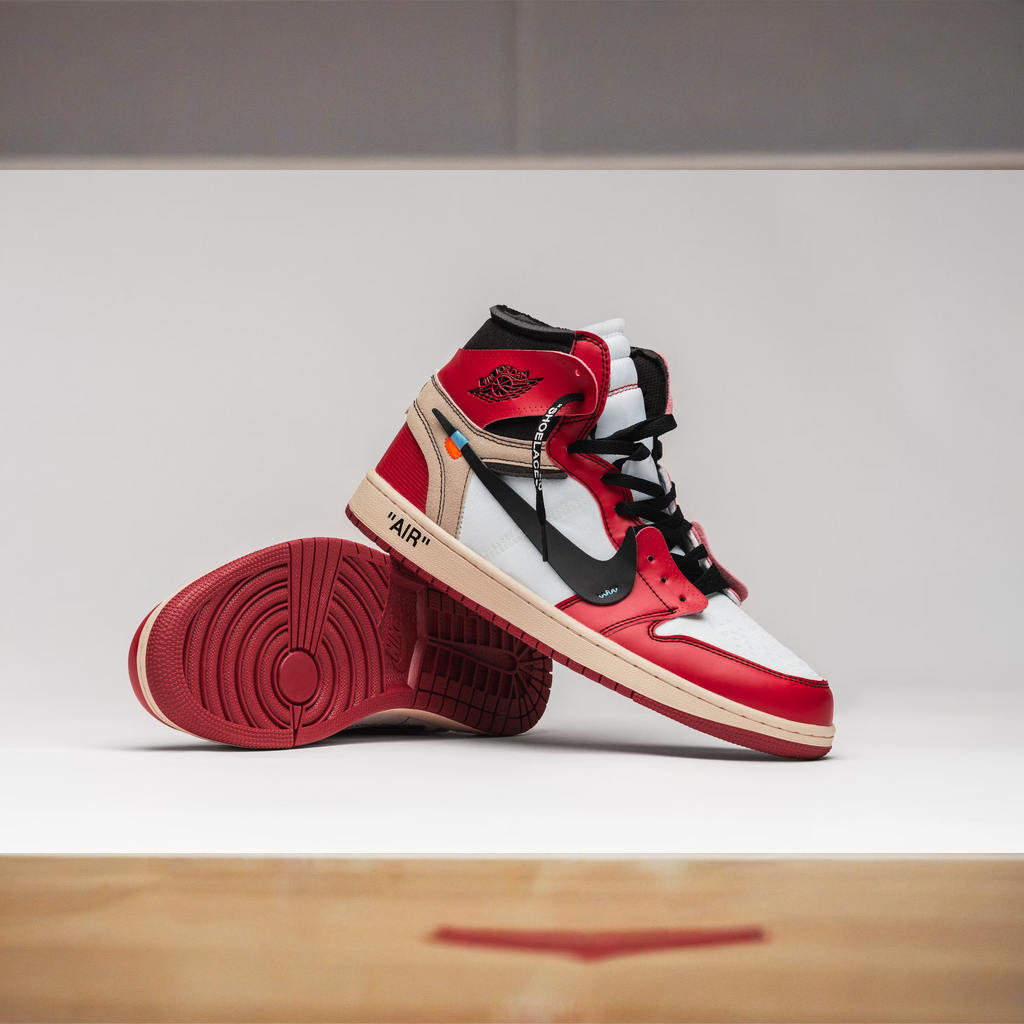

In [5]:
x = (1024 - resized_img.width) // 2
y = (1024 - resized_img.height) // 2
temp_image.paste(resized_img, (x, y), resized_img)
temp_image

이제 초기 outpainting된 이미지를 바탕으로 RealVisXL Model과 StableDiffusionXLInpaintPipeline을 로드하여 더 나은 품질의 최종 이미지를 만들어냅니다. 

In [6]:
pipeline = StableDiffusionXLInpaintPipeline.from_pretrained(
    "OzzyGT/RealVisXL_V4.0_inpainting",
    torch_dtype=torch.float16,
    variant="fp16",
    vae=vae,
).to("cuda")

Loading pipeline components...: 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]


최종적으로 outpainting된 이미지에 대해 마스크를 준비합니다. 원본 이미지와 outpainting된 배경 사이에 보다 자연스러운 연결을 만드려면 마스크를 blur처리하여 더 잘 혼합되도록 합니다. 

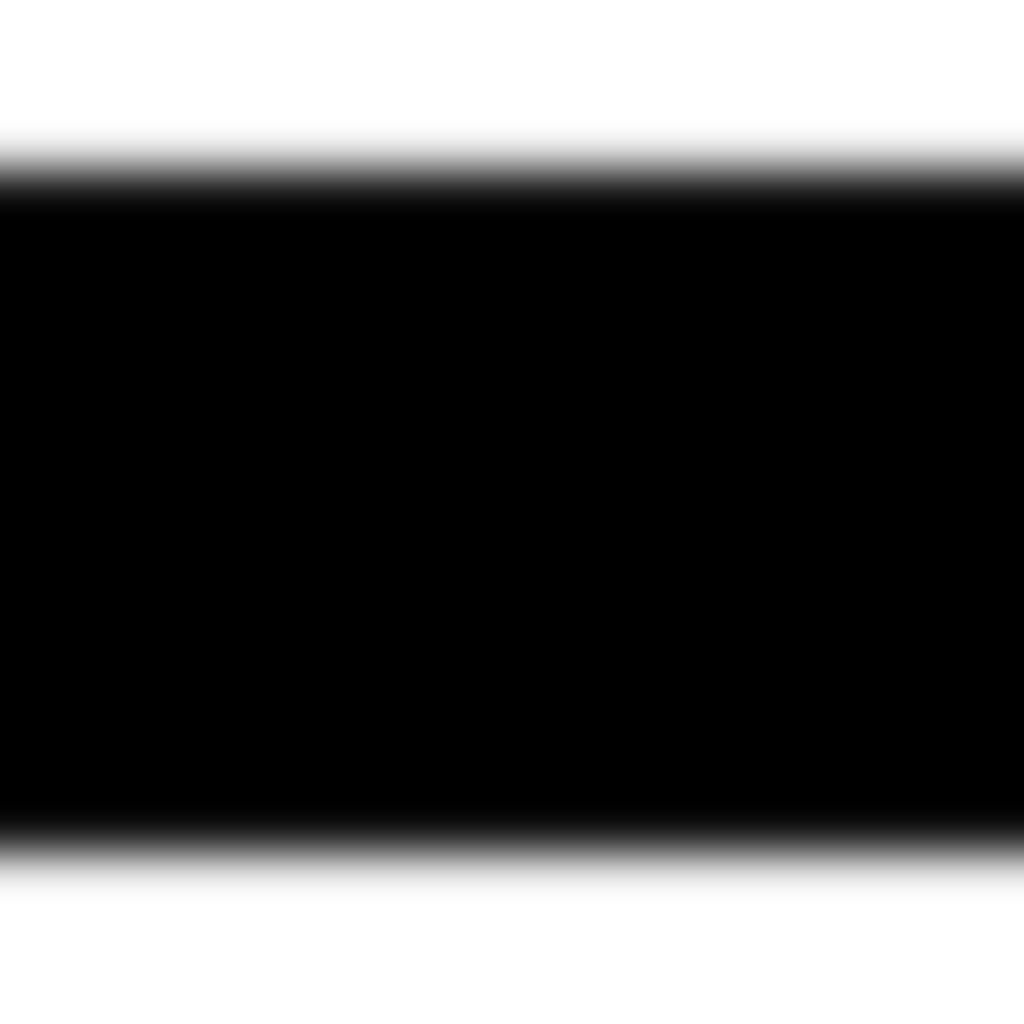

In [7]:
mask = Image.new("L", temp_image.size)
mask.paste(resized_img.split()[3], (x, y))
mask = ImageOps.invert(mask)
final_mask = mask.point(lambda p: p > 128 and 255)
mask_blurred = pipeline.mask_processor.blur(final_mask, blur_factor=20)
mask_blurred

더 나은 prompt를 생성하고 이를 generate_outpaint 함수에 전달해 최종 outpainting된 이미지를 생성합니다. 그 다음 원본 이미지를 outpainting된 이미지 위에 붙여넣습니다. 

100%|██████████| 24/24 [00:05<00:00,  4.21it/s]


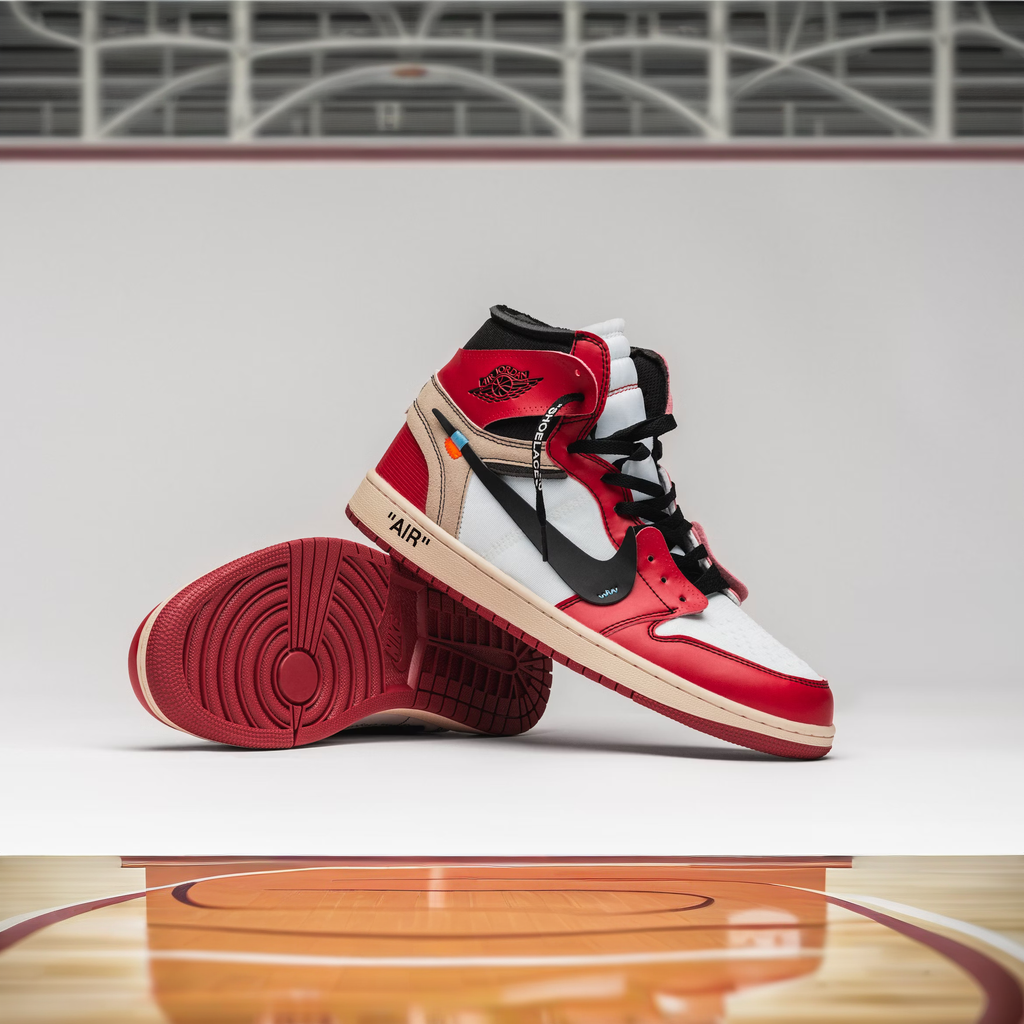

In [8]:
def generate_outpaint(prompt, negative_prompt, image, mask, seed: int = None):
    if seed is None:
        seed = random.randint(0, 2**32 - 1)

    generator = torch.Generator(device="cpu").manual_seed(seed)

    image = pipeline(
        prompt,
        negative_prompt=negative_prompt,
        image=image,
        mask_image=mask,
        guidance_scale=10.0,
        strength=0.8,
        num_inference_steps=30,
        generator=generator,
    ).images[0]

    return image

prompt = "high quality photo of nike air jordans on a basketball court, highly detailed"
# prompt = "high quality photo of addias soccer shoes on a soccer field, highly detailed"
negative_prompt = ""

final_image = generate_outpaint(prompt, negative_prompt, temp_image, mask_blurred, 7688778)
x = (1024 - resized_img.width) // 2
y = (1024 - resized_img.height) // 2
final_image.paste(resized_img, (x, y), resized_img)
final_image